# Data Scientist Job Description Analysis

In [270]:
# general
import pandas as pd
import numpy as np
import time

# web scrape
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup

# preprocess
import re
import nltk
import spacy
nlp = spacy.load("en")
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer

# word embeddings
from gensim.models import KeyedVectors, Word2Vec

# clustering
from sklearn.cluster import SpectralClustering

# word cloud visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# Collect Job Postings
**for Data Scientists in Canada**

In [530]:
# collect job descriptions
jd_list = []
companies = []
search_position = "data+scientist"
search_location = "Canada"
min_posts = 50

url = "https://www.indeed.ca/"

while len(jd_list) < min_posts:
    time.sleep(1)
    ds_filter = "jobs?q="+search_position+"&l="+search_location+"&limit=50"
    req = requests.get(url+ds_filter)
    main_soup = BeautifulSoup(req.text, "lxml")
    # get links
    main_page = main_soup.findAll("div", attrs={"class": "jobsearch-SerpJobCard"})
    for i in main_page:
        company = i.find("span", attrs={"class": "company"}).text.strip().lower()
        position = i.find("div", attrs={"class":"title"}).find("a")["title"].lower()
        
        if ("data scientist" in position) and (company not in companies):
            link_filter = "viewjob?jk="+i["data-jk"]
            page_req = requests.get(url+link_filter)
            page_soup = BeautifulSoup(page_req.text, "lxml")
            job_details = page_soup.find("div", attrs={"id":"jobDescriptionText"})
            
            # keep track of titles to reduce duplicates
            companies.append(company)
            # append job description
            jd_list.append(str(job_details))
        else:
            continue

# Preprocess Job Postings


In [399]:
def preprocess(text, min_token_len = 2):
    """
    Simple preprocessor that removes html tags and tokenizes text.
    
    Return: string
    """
    text = re.compile(r'<.*?>').sub("", text)
    
     # Create doc
    doc = nlp(text)
    
    # Remove everything in step 3
    tokens = [str(token).lower() for token in doc if not token.is_stop and len(token) >= min_token_len]
    token_join = " ".join(tokens)
    
    # use gensim's preprocessing function (might be better than our own)
    simple = gensim.utils.simple_preprocess(str(token_join), deacc=True)
    
    return " ".join(simple)

In [138]:
data = pd.DataFrame({"text":jd_list})
data.head()

# or you could read in my data using data = pd.read_csv("data/job_text.csv", index_col=0)

,text
0,"<div class=""jobsearch-jobDescriptionText"" id=""..."
1,"<div class=""jobsearch-jobDescriptionText"" id=""..."
2,"<div class=""jobsearch-jobDescriptionText"" id=""..."
3,"<div class=""jobsearch-jobDescriptionText"" id=""..."
4,"<div class=""jobsearch-jobDescriptionText"" id=""..."


In [139]:
# create "clean" and "tokens" columns
data["clean"] = data["text"].apply(preprocess)
data["tokens"] = data["clean"].apply(lambda x: x.split())

In [271]:
# uncomment the row below to save data
# data.to_csv("data/job_text.csv")

# TF-IDF Keyword Extraction

In [142]:
# create list of job postings
text_list = data["clean"].tolist()

In [143]:
# train vectorizer
vectorizer = TfidfVectorizer(use_idf=True, tokenizer=nltk.word_tokenize)
tfidf_vectors = vectorizer.fit_transform(text_list)

In [400]:
def tfidf_topk_words(vectorizer, k=20):
    """
    A keyword extraction function that takes in a TFIDF Vectorizer 
    and returns the top k keywords
    """
    words = np.array(vectorizer.get_feature_names())
    tfidfs = tfidf_vectors.toarray()

    topk = np.array([np.argpartition(i, -k)[-k:] for i in tfidf_vectors.toarray()])
    return words[topk]


In [145]:
# create list of top k words for each job posting
top20_words = tfidf_topk_words(vectorizer, k=20)

# Fine Tune Word Embeddings

In [276]:
# load GoogleNews word embeddings
# please download this yourself
model = KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)

In [ ]:
# create vocab
vocabulary = data["tokens"].tolist()

In [277]:
# fine tune word2vec model
model2 = Word2Vec(size=300, min_count=1)
model2.build_vocab(vocabulary)
model2.build_vocab([list(model.vocab.keys())], update=True)
model2.intersect_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True, lockf=1.0)
model2.train(vocabulary, total_examples=len(vocabulary), epochs = 5)

/Users/patricktung/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(90130, 90130)

In [278]:
# save model
# model2.save("data/word2vec300.model")

## Create embeddings for each post

In [280]:
# each post would be an average of the keyword embeddings
post_embeddings = np.array([model2.wv[top20_words[i]].mean(axis=0) for i in range(len(top20_words))])

In [281]:
# should be size (num_posts, num_features)
post_embeddings.shape

(52, 300)

# Spectral Clustering

In [513]:
# num_clusters is set to sqrt(num_posts), 
# but could use better methods to choose optimal number of clusters
num_clusters = np.floor(np.sqrt(post_embeddings.shape[0])).astype("int")

# create clusters
cluster = SpectralClustering(n_clusters=num_clusters, 
                             assign_labels="discretize", random_state=101).fit(post_embeddings)

In [514]:
# number of posts in each cluster
pd.Series(cluster.labels_).value_counts()

3    12
0    11
5     8
1     7
6     6
2     6
4     2
dtype: int64

## Explore clusters

In [515]:
def get_keywords_by_cluster(cluster, label):
    """
    Given a cluster and cluster label, return the topk_words
    for each post in the cluster
    """
    cluster_index = np.array(cluster.labels_ == label)
    return top20_words[cluster_index]

### Cluster 0

Note: keywords are in no particular order

In [516]:
get_keywords_by_cluster(cluster,0)

array([['growing', 'project', 'flexible', 'machine', 'data', 'new',
        'continuous', 'share', 'feedback', 'encourages', 'deploy',
        'team', 'small', 'learning', 'geese', 'product', 'continue',
        'work', 'heard', 'enjoy'],
       ['application', 'following', 'management', 'work', 'government',
        'recent', 'canada', 'specialization', 'stream', 'contact',
        'essential', 'significant', 'process', 'normally', 'information',
        'experience', 'defined', 'data', 'public', 'ec'],
       ['solutions', 'experience', 'work', 'reporting', 'com', 'great',
        'data', 'resume', 'collection', 'candidates', 'bring', 'things',
        'let', 'actuarial', 'sonnet', 'company', 'insurance', 're',
        'petline', 'economical'],
       ['use', 'benefits', 'turn', 'family', 'location', 'http', 'nlu',
        'https', 'eligible', 'url', 'echo', 'www', 'amazon', 'home',
        'youtube', 'alexa', 'smart', 'com', 'bonuses', 'watch'],
       ['engineering', 'functional', 

The posts in cluster 0 look like they might something to do with machine learning or deep learning. We can see "ml" being used, as well as, "learning" and "deep". It also labeled an Amazon job posting in here about the Echo and Alexa, which could mean something about nlp.

### Cluster 1

In [517]:
get_keywords_by_cluster(cluster,1)

array([['processing', 'technical', 'fields', 'scientific', 'human',
        'behaviour', 'understanding', 'data', 'contributing', 'code',
        'linguistics', 'ideal', 'new', 'background', 'work',
        'psychology', 'keen', 'insights', 'receptiviti', 'modelling'],
       ['project', 'experience', 'ensure', 'modeling', 'pipelines',
        'candidates', 'similar', 'push', 'collaboratively', 'program',
        'server', 'probability', 'rd', 'association', 'simulation',
        'tableau', 'levels', 'data', 'analytics', 'bcmea'],
       ['mining', 'decisions', 'internal', 'success', 'marketing',
        'team', 'improving', 'organizational', 'analysis', 'designing',
        'quantitative', 'help', 'extract', 'game', 'interpersonal',
        'initiatives', 'data', 'player', 'qualitative', 'gaming'],
       ['maritime', 'trending', 'trends', 'new', 'pipelines', 'tableau',
        'creative', 'push', 'bcmea', 'bc', 'degree', 'support',
        'resource', 'association', 'levels', 'progra

In regards to cluster 1, it looks like the most important word that makes these posts a "cluster" is the keyword "data". However, simply having "data" does not really tell us any key skills data scientists have or need.

### Cluster 2

In [518]:
get_keywords_by_cluster(cluster, 2)

array([['america', 'alongside', 'users', 'software', 'parents',
        'incredible', 'north', 'prodigy', 'advancement', 'kids',
        'education', 'data', 'love', 'students', 'educational', 'help',
        'teachers', 'growing', 'entire', 'teams'],
       ['meeting', 'stay', 'accessibility', 'change', 'want', 'excited',
        'data', 'mind', 'rewarded', 'iteration', 'business', 'delivers',
        'success', 'work', 'entrepreneurial', 'employees', 'afraid',
        'thrive', 'achievers', 'places'],
       ['advanced', 'modeling', 'background', 'partners', 'core', 'plus',
        'leader', 'industry', 'apply', 'north', 'highly', 'underwriting',
        'munich', 'insurance', 'life', 'employees', 'american', 'data',
        'rewards', 'science'],
       ['convincing', 'authority', 'alliteratively', 'principal',
        'broad', 'evolved', 'networking', 'instruments', 'cryptoassets',
        'team', 'mentorship', 'projects', 'excellent', 'data',
        'collaboration', 'learning', '

Cluster 2 looks like it contains a little information about education, teams and maybe collaboration. This could mean that these posts are either geared towards students, mentorships, or simply positions that require teamwork.

### Cluster 3

In [519]:
get_keywords_by_cluster(cluster, 3)

array([['ai', 'like', 'possible', 'grow', 'way', 'execute', 'client',
        'identify', 'data', 'need', 'ca', 'connect', 'exposure',
        'launch', 'deloitte', 'look', 'lead', 'prepped', 'firm', 'omnia'],
       ['automated', 'dashboards', 'game', 'days', 'information',
        'toronto', 'welcomes', 'intermediate', 'annual', 'located',
        'assisting', 'classes', 'team', 'tasks', 'excellent', 'studio',
        'data', 'ability', 'ubisoft', 'events'],
       ['focus', 'specific', 'making', 'training', 'skills', 'domain',
        'accessible', 'curation', 'cleansing', 'openly', 'automation',
        'automating', 'preparation', 'manual', 'salesgrowth',
        'automatic', 'efficiently', 'ml', 'data', 'information'],
       ['grasp', 'narratives', 'author', 'users', 'understanding',
        'analyses', 'engineering', 'production', 'key', 'provide',
        'inform', 'metrics', 'data', 'closely', 'flashfood', 'decisions',
        'surplus', 'experimentation', 'phone', 'food'],
 

As we have seen earlier, cluster 3 is our largest cluster and that is a little bit worrisome. After looking at all the other clusters, it looks like this cluster might just be of some miscellaneous information. It contains keywords such as "ai", "modelling", and "experimentation", but these are not shared across the posts. 

### Cluster 4

In [520]:
get_keywords_by_cluster(cluster, 4)

array([['competences', 'automatique', 'technologies', 'que', 'un', 'une',
        'pour', 'apprentissage', 'vous', 'le', 'en', 'la', 'les', 'des',
        'donnees', 'ericsson', 'mi', 'de', 'dans', 'et'],
       ['dans', 'aux', 'modeles', 'vb', 'speech', 'va', 'connaissance',
        'de', 'la', 'des', 'un', 'nuance', 'les', 'pour', 'ivr', 'le',
        'ou', 'et', 'en', 'avec']], dtype='<U15')

This cluster is very interesting and is quite obvious. Having had some introductory French lessons, it looks to me that this cluster consists of posts that are in French. We can also see that some of the important words are "technologies" and "modeles".

### Cluster 5

In [521]:
get_keywords_by_cluster(cluster, 5)

array([['seekers', 'minute', 'traits', 'application', 'sure', 'free',
        'employers', 'career', 'considered', 'job', 'qualities', 'dream',
        'matched', 'companies', 'stand', 'tech', 'roles', 'ready',
        'prime', 'coaching'],
       ['youyou', 'yearexperience', 'skillsbonus', 'inertial', 'improve',
        'years', 'timesalary', 'developed', 'boundaries', 'foundations',
        'navigation', 'underground', 'underpin', 'breakthroughs',
        'physicist', 'required', 'forpractical', 'needstrong', 'dobe',
        're'],
       ['canada', 'documents', 'limited', 'scotiabankers', 'assistance',
        'interpreter', 'scotiabank', 'candidates', 'assistive',
        'alternate', 'id', 'requisition', 'asl', 'brings', 'recruitment',
        'require', 'bank', 'interview', 'accessible', 'global'],
       ['personal', 'paid', 'days', 'dynamic', 'office', 'potential',
        'hard', 'free', 'yoga', 're', 'vancouver', 'visier', 'fun',
        'gym', 'classes', 'games', 'manager', 

Similar to cluster 3, this cluster seems a little bit of everywhere. I don't think that this cluster has a main idea or keyword. However, we are able to see that some of the keywords for a particular post seem to quite interesting. For example, we can see that there is a job posting that requires the data scientists to understand ajax, html, laravel, and css. This looks more like a web development position, but I do not think this is essential for data scientists.

### Cluster 6

In [522]:
get_keywords_by_cluster(cluster, 6)

array([['testing', 'preferred', 'scientist', 'analytics', 'applied',
        'analytical', 'applying', 'etc', 'calgary', 'day', 'data',
        'statistical', 'machine', 'including', 'learning', 'integrity',
        'techniques', 'clients', 'products', 'science'],
       ['messaging', 'visualization', 'requirements', 'analytics', 'll',
        'user', 'analysis', 'techniques', 'life', 'identify', 'ability',
        'demonstrated', 'tools', 'business', 'unstructured', 'learning',
        'workflows', 'experience', 'data', 'information'],
       ['innovative', 'data', 'peoplestrong', 'learning', 'execution',
        'techniques', 'production', 'new', 'amp', 'organization',
        'recordbachelors', 'use', 'models', 'improvementa',
        'managementtest', 'tools', 'machine', 'analytics', 'job',
        'desciption'],
       ['amp', 'execution', 'company', 'technical', 'techniques', 'opta',
        'description', 'new', 'learning', 'bachelors', 'organization',
        'tools', 'models',

Cluster 6 seems to be about analyzing data and providing insights. Some of the keywords used here are "analytics" and "analyzing". I must agree that data scientists should know how to analyze information and generate insights from their analysis.

# Word Cloud Visualization

To visualize what the most frequent words that appeared in our entire dataset, we can create a word cloud.

In [436]:
# generate a word cloud of 50 words
word_cloud_text = " ".join(text_list)
wc = WordCloud(max_words=100, scale=30, background_color="white").generate(word_cloud_text)

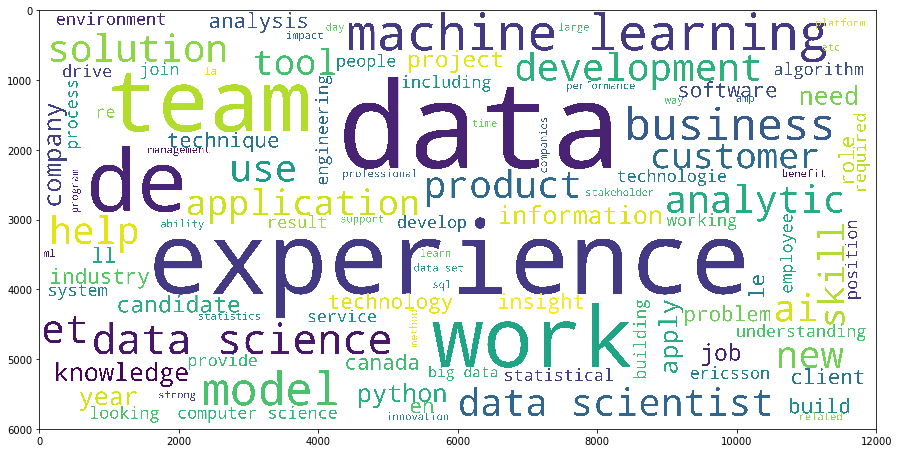

In [437]:
# visualize
plt.figure(figsize=(15,15))
plt.imshow(wc)

It seems that there still needs to be some preprocessing work needed to be done in terms of the word cloud generated from the previous cell. However, we can still gain some quick insights about what type of information is included in our data scientist job postings. We can definitely see that "machine learning" is a big part, as well as "model", "algorithm", and "statistical". In terms of the types of coding languages that data scientists should use, although it's quite small, I can see that there is "python" and "sql". 